# Feature Ablation特征消融可解释性分析

根据实例分割标注图，分别除去图像中的不同语义分组区域，观察对模型预测结果的影响。

同济子豪兄 https://space.bilibili.com/1900783

代码运行云GPU平台：https://featurize.cn/?s=d7ce99f842414bfcaea5662a97581bd1

2022-8-20

参考教程：https://captum.ai/tutorials/Resnet_TorchVision_Ablation

## 导入工具包

In [1]:
import torch
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision import models

from captum.attr import visualization as viz
from captum.attr import FeatureAblation

from PIL import Image
import numpy as np

import os
import json

import matplotlib.pyplot as plt
%matplotlib inline

## 载入预训练ResNet模型

In [2]:
model = models.resnet18(pretrained=True)
model = model.eval()

## 载入ImageNet 1000图像分类标签

In [3]:
import pandas as pd
df = pd.read_csv('imagenet_class_index.csv')
idx_to_labels = {}
idx_to_labels_cn = {}
for idx, row in df.iterrows():
    idx_to_labels[row['ID']] = row['class']
    idx_to_labels_cn[row['ID']] = row['Chinese']

In [4]:
# idx_to_labels

## 载入图像文件和实例分割标注文件

图像来自 VOC 2012 数据集

In [6]:
img_path = 'test_img/2007_002953.jpg'
mask_path = 'test_img/2007_002953_mask.png'

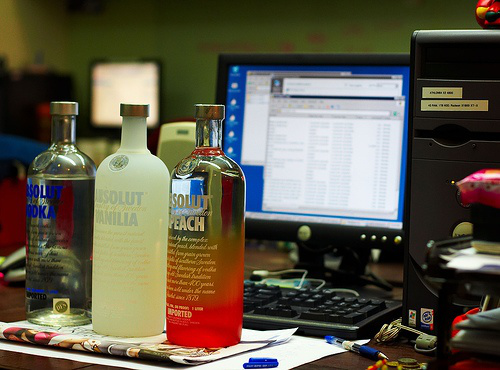

In [7]:
img = Image.open(img_path)
img

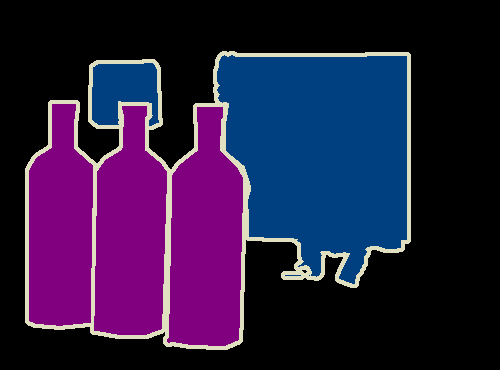

In [8]:
mask_img = Image.open(mask_path)
mask_img

In [9]:
np.unique(mask_img)

array([  0,   5,  20, 255], dtype=uint8)

[0, 5, 20, 255]对应 VOC 数据集中的 background, bottle, tvmonitor void 四个类别。

## 预处理

In [10]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])
])

In [11]:
input_tensor = transform(img).unsqueeze(0)

## 模型预测

In [12]:
pred_logits = model(input_tensor)
pred_softmax = F.softmax(pred_logits, dim=1)

## 解析图像分类预测结果

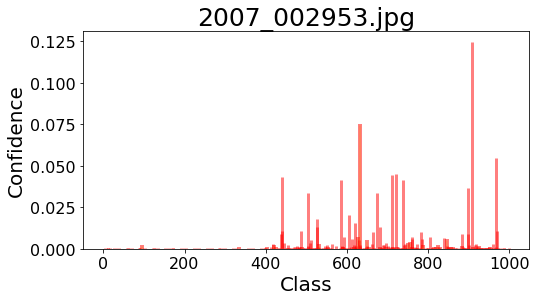

In [13]:
plt.figure(figsize=(8,4))

x = range(1000)
y = pred_softmax.cpu().detach().numpy()[0]

ax = plt.bar(x, y, alpha=0.5, width=0.3, color='yellow', edgecolor='red', lw=3)
# plt.ylim([0, 1.0]) # y轴取值范围
# plt.bar_label(ax, fmt='%.2f', fontsize=15) # 置信度数值

plt.xlabel('Class', fontsize=20)
plt.ylabel('Confidence', fontsize=20)
plt.tick_params(labelsize=16) # 坐标文字大小
plt.title(img_path, fontsize=25)

plt.show()

In [14]:
n = 10
top_n = torch.topk(pred_softmax, n)
pred_ids = top_n[1].cpu().detach().numpy().squeeze() # 解析出类别
confs = top_n[0].cpu().detach().numpy().squeeze() # 解析出置信度

for i in range(n):
    class_name = idx_to_labels[pred_ids[i]] # 获取类别名称
    confidence = confs[i] * 100 # 获取置信度
    text = '{:<15} {:>.4f}'.format(class_name, confidence)
    print(text)

wine_bottle     12.4709
lotion          7.4601
red_wine        5.4811
pill_bottle     4.4971
perfume         4.4218
beer_bottle     4.3309
pop_bottle      4.1627
hair_spray      4.1394
water_bottle    3.6489
mouse           3.3743


## 最高置信度预测结果

In [15]:
pred_conf, pred_id = torch.topk(pred_softmax, 1)
pred_conf = pred_conf.detach().cpu().numpy().squeeze().item()
pred_id = pred_id.detach().cpu().numpy().squeeze().item()
pred_label = idx_to_labels[pred_id]

In [16]:
print('最高置信度预测类别', pred_label)

最高置信度预测类别 wine_bottle


提示：图像分类假设图中仅有一个物体，如果有多个类别的多个物体，会略微干扰预测结果。

## feature group 特征分组

在实例分割标注图中，每一个类别都被划为一类 feature group。

Feature Ablation 就是分析每个 feature group 存在（或者不存在）的影响。

In [17]:
# 将实例分割标注图像转为 count, channels, height, width 维度
feature_mask = np.array(mask_img.getdata()).reshape(1, 1, mask_img.size[1], mask_img.size[0])

In [18]:
feature_mask.shape

(1, 1, 370, 500)

In [19]:
np.unique(feature_mask)

array([  0,   5,  20, 255])

In [20]:
# 将实例分割标注图转为从 1 开始的标注值（而不是 0-255 的256个标注值），便于后续处理。
feature_mask[feature_mask == 5] = 1 # bottle
feature_mask[feature_mask == 20] = 2 # tvmonitor
feature_mask[feature_mask == 255] = 3 # void

In [21]:
np.unique(feature_mask)

array([0, 1, 2, 3])

## Feature Ablation 可解释性分析

In [22]:
ablator = FeatureAblation(model)

### 最高置信度类别（wine bottle）

In [23]:
# 计算每个 feature group 对模型预测为 pred_id对应类别 概率的影响
attribution_map = ablator.attribute(input_tensor, target=pred_id, feature_mask=torch.tensor(feature_mask))
attribution_map = attribution_map.detach().cpu().numpy().squeeze()
attribution_map = np.transpose(attribution_map, (1,2,0))

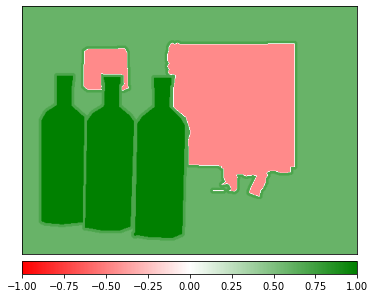

In [24]:
viz.visualize_image_attr(attribution_map,
                         method="heat_map",
                         sign="all",
                         show_colorbar=True)
plt.show()

从图中可以看出，绿色最深的区域为酒瓶对应的区域，证明酒瓶区域对模型预测为 wine_bottle 的影响最大，如果抹掉该区域，会对模型预测为 wine_bottle 的概率产生较大负面影响。

背景区域的影响较小。如果抹掉该区域，会对模型预测为 wine_bottle 的概率产生较小负面影响。

显示器区域为红色，如果抹掉该区域，会对模型预测为 wine_bottle 的概率产生正面积极影响。

### 更换类别为 tv_monitor（664）

In [25]:
attribution_map = ablator.attribute(input_tensor, target=664, feature_mask=torch.tensor(feature_mask))
attribution_map = attribution_map.detach().cpu().numpy().squeeze()
attribution_map = np.transpose(attribution_map, (1,2,0))

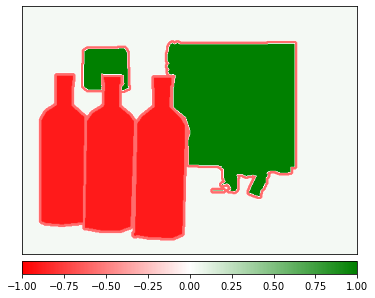

In [26]:
viz.visualize_image_attr(attribution_map,
                         method="heat_map",
                         sign="all",
                         show_colorbar=True)
plt.show()

从图中可以看出，绿色最深的区域为显示器对应的区域，证明显示器区域对模型预测为 tv_monitor 的影响最大，如果抹掉该区域，会对模型预测为 tv_monitor 的概率产生较大负面影响。

背景区域的影响较小。如果抹掉该区域，影响较小。

酒瓶区域 和 边缘区域 为红色，如果抹掉该区域，会对模型预测为 tv_monitor 的概率产生正面积极影响。

思考：边缘区域为什么是红色？

## Sanity check 抹掉酒瓶和边缘区域

In [27]:
import cv2

In [28]:
new_mask = np.array(feature_mask)
new_mask[feature_mask == 0] = 1 # wine_bottle
new_mask[feature_mask == 1] = 0 # 背景
new_mask[feature_mask == 2] = 1 # tv_monitor
new_mask[feature_mask == 3] = 0 # 边缘
new_mask = np.expand_dims(new_mask.squeeze(), axis=2).astype(np.uint8)

img_without_bottles = cv2.bitwise_and(np.array(img), np.array(img), mask=new_mask)
img_without_bottles = cv2.cvtColor(img_without_bottles, cv2.COLOR_BGR2RGB)

cv2.imwrite('img_without_bottles.jpg', img_without_bottles)

True

In [29]:
img = Image.open('img_without_bottles.jpg')

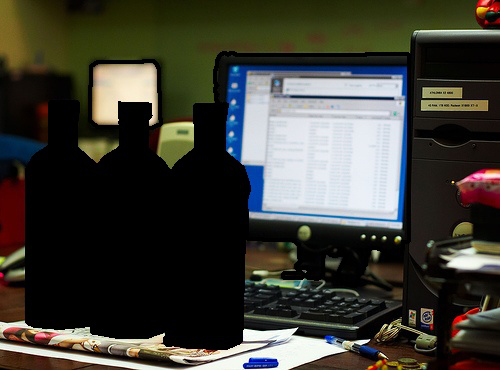

In [30]:
img

预处理、模型前向预测

In [31]:
input_tensor = transform(img).unsqueeze(0)
pred_logits = model(input_tensor)
pred_softmax = F.softmax(pred_logits, dim=1)

解析模型预测结果

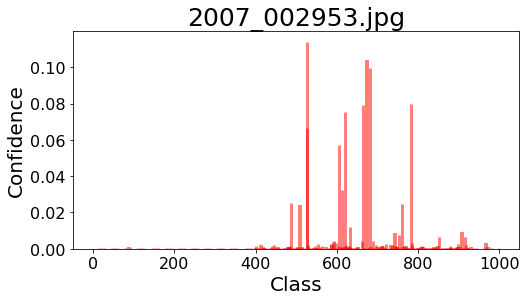

In [32]:
plt.figure(figsize=(8,4))

x = range(1000)
y = pred_softmax.cpu().detach().numpy()[0]

ax = plt.bar(x, y, alpha=0.5, width=0.3, color='yellow', edgecolor='red', lw=3)
# plt.ylim([0, 1.0]) # y轴取值范围
# plt.bar_label(ax, fmt='%.2f', fontsize=15) # 置信度数值

plt.xlabel('Class', fontsize=20)
plt.ylabel('Confidence', fontsize=20)
plt.tick_params(labelsize=16) # 坐标文字大小
plt.title(img_path, fontsize=25)

plt.show()

In [33]:
n = 10
top_n = torch.topk(pred_softmax, n)
pred_ids = top_n[1].cpu().detach().numpy().squeeze() # 解析出类别
confs = top_n[0].cpu().detach().numpy().squeeze() # 解析出置信度

for i in range(n):
    class_name = idx_to_labels[pred_ids[i]] # 获取类别名称
    confidence = confs[i] * 100 # 获取置信度
    text = '{:<15} {:>.4f}'.format(class_name, confidence)
    print(text)

desktop_computer 11.4071
mouse           10.3340
notebook        9.9397
screen          7.9616
monitor         7.9415
laptop          7.5611
desk            6.6604
iPod            5.7354
joystick        3.2164
cellular_telephone 2.5471
